In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#pre-process text 
import nltk
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

#transform data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

#model libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

#import log function 
from sklearn.metrics import log_loss

%matplotlib inline

# Spooky Author

### Load Corpus of Spooky Authors dataset

In [2]:
#load train data to Pandas dataframe
train_df = pd.read_csv('train.csv')
#load test data
test_df = pd.read_csv('test.csv')

### Basic EDA on train and test data using Pandas and Seaborn

In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
test_df.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [6]:
train_df.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id07525,Pestilence then made a pause in her death deal...,EAP
freq,1,1,7900


In [7]:
test_df.describe()

,id,text
count,8392,8392
unique,8392,8392
top,id26558,"I burned to say if but one word, by way of tri..."
freq,1,1


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
id      8392 non-null object
text    8392 non-null object
dtypes: object(2)
memory usage: 131.2+ KB


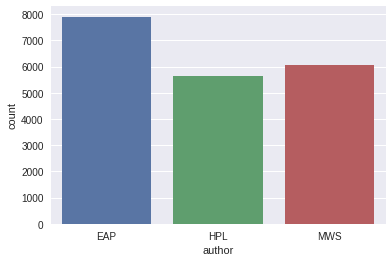

In [10]:
sns.countplot('author',data = train_df)
plt.show()

Classes seem balanced across three authors, which informs my approach in splitting the training data for analysis.

### Label Encode Authors

Here, I am changing the target variable from acronyms of authors to numbers. Since three variables exist, variables are given numbers 0, 1, and 2.

In [11]:
#import label encoder to transform target variables
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()
train_df['author_numerical'] = le.fit_transform(train_df['author'])

In [13]:
train_df.head()

,id,text,author,author_numerical
0,id26305,"This process, however, afforded me no means of...",EAP,0
1,id17569,It never once occurred to me that the fumbling...,HPL,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,1


### Split data into train and valid sets

Train-test-split the training set into training set and validation set to train our model which will then be used on the actual test data test_df. 

In [14]:
Y = train_df['author_numerical']

In [15]:
#split the training data with the label-encoded column as the target 
x_train, X_valid, y_train, Y_valid = train_test_split(train_df.text.values, Y, 
                                                      random_state=42,
                                                      test_size=0.1)

### Pre-Process and Rescale Data

In [16]:
stemmer = PorterStemmer()

Discard structure of the text using bag-of-words representation to see how often each word appears in each text in the corpus.

In [17]:
#process text using stemmer to regularize text
def stem_tokens(tokens, stemmer): 
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#turn texts to tokens 
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if len(i) > 2] #gets rid of 1-2 character tokens
    stems = stem_tokens(tokens, stemmer)
    return stems

In [18]:
#stop_words = 'engish' uses the built-in list ENGLISH_STOP_WORDS
#discarding all words that show up less than twice (min_df = 2)
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df = 2, stop_words = 'english')

In [19]:
#fit the training set before transforming data
tfidf_vectorizer.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x7ff6d3e46840>, use_idf=True,
        vocabulary=None)

In [20]:
#transform train set and validation set into tfidf vectors
x_train_tfidf = tfidf_vectorizer.transform(x_train) 
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

In [21]:
print(X_valid_tfidf.shape, x_train_tfidf.shape)

(1958, 9726) (17621, 9726)


### Fit to model

I chose Logistic Regression, Multinomial NB, and Random Forest. Before applying each model I used GridSearch CV to determine optimal hyperparameters to train my models.

In [22]:
lr_params = {
    'C':np.logspace(-3,3,7),
    'penalty':['l2','l1']
}

In [23]:
lrgs = GridSearchCV(LogisticRegression(),
                    param_grid=lr_params,
                    cv=StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42))

In [24]:
lrgs.fit(x_train_tfidf, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]), 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
lrgs.best_score_

0.81225531914893612

In [26]:
lrgs.best_params_

{'C': 10.0, 'penalty': 'l2'}

In [27]:
# Fitting Logistic Regression on TFIDF using best params
clf = LogisticRegression(C=10.0, penalty='l2')
clf.fit(x_train_tfidf, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
probas = clf.predict_proba(X_valid_tfidf)

log_loss(Y_valid, probas)

0.50293098006304271

### Multinomial NB

In [29]:
params = {'alpha':[0.01, 0.1, 1.0, 10.0, 100.0]}
grid_nb = GridSearchCV(MultinomialNB(), 
                       param_grid=params, 
                       cv=StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42))
grid_nb.fit(x_train_tfidf, y_train)
grid_nb.best_params_

{'alpha': 0.1}

In [30]:
# use the best params
nb = MultinomialNB(alpha=0.1)
# fit the model 
nb.fit(x_train_tfidf, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [31]:
probas = nb.predict_proba(X_valid_tfidf)

log_loss(Y_valid, probas)

0.47651461290289437

### RandomForest

In [32]:
# grid search on random forest took too long, will try one version
grid_forest = RandomForestClassifier(n_estimators=100)
grid_forest.fit(x_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [33]:
probas = grid_forest.predict_proba(X_valid_tfidf)

log_loss(Y_valid, probas)

0.73472052096266138

### Transform test data using the model that had the best score: MultinomialNB

In [35]:
X_test = test_df.text.values

In [36]:
test_tfidf = tfidf_vectorizer.transform(X_test) 

In [37]:
probas = nb.predict_proba(test_tfidf)

preds = nb.predict(test_tfidf)

In [38]:
len(probas)

8392

In [39]:
len(preds)

8392

In [40]:
final = pd.DataFrame(probas, index=test_df['id'], columns=['EAP', 'HPL', 'MWS'])

In [41]:
final.head()

,EAP,HPL,MWS
id,,,
id02310,0.055245,0.024885,0.919870
id24541,0.859257,0.081845,0.058899
id00134,0.291505,0.656829,0.051665
id27757,0.479138,0.516269,0.004593
id04081,0.778883,0.127610,0.093508


In [42]:
final.to_csv('final.csv')